# Virtual environment

## Set virtual environment

In [1]:
!pip install virtualenv

## Use virtual environment

In [2]:
!virtualenv ga_pokemon_battles
!source ga_pokemon_battles/bin/activate

created virtual environment CPython3.11.7.final.0-64 in 186ms
  creator CPython3Posix(dest=/home/jovyan/ga_pokemon_battles, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/jovyan/.local/share/virtualenv)
    added seed packages: pip==24.0, setuptools==69.5.1, wheel==0.43.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


# Install libraries

In [3]:
!pip install deap pokebase

# Import libraries

In [4]:
from deap import tools
import json
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import logging
import pokebase as pb
from pokebase import cache
from deap import creator, base, tools, algorithms
from functools import partial
from concurrent.futures import ThreadPoolExecutor
from deap import tools
from multiprocessing import Pool
import time

# Set logic for GA

In [5]:
# Set up cache for pokebase
cache.API_CACHE

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def initialize_deap():
    """ Initializes the DEAP creator for fitness and individual. """
    class_names = ["FitnessMax", "Individual"]
    for class_name in class_names:
        if class_name in creator.__dict__:
            delattr(creator, class_name)
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

def fetch_all_pokemon(data_path):
    """ Fetches all Pokémon data and saves to a JSON file. """
    all_pokemon = {}
    for pokemon_id in range(1, 1026):
        try:
            pokemon = pb.pokemon(pokemon_id)
            all_pokemon[pokemon.name] = {
                'name': pokemon.name,
                'stats': {stat.stat.name: stat.base_stat for stat in pokemon.stats}
            }
        except Exception as e:
            logging.error(f"Failed to fetch Pokémon ID {pokemon_id}: {e}")
            continue
    with open(data_path, 'w') as f:
        json.dump(all_pokemon, f, indent=4)
    logging.info(f"Fetched data for {len(all_pokemon)} Pokémon.")
    return all_pokemon

def load_pokemon_data(data_path):
    """ Loads Pokémon data from a file or fetches it if the file doesn't exist. """
    if not os.path.exists(data_path):
        print("Pokemon data file not found, fetching data...")
        return fetch_all_pokemon(data_path)
    else:
        print("Loading pokemon data from file...")
        with open(data_path, 'r') as f:
            return json.load(f)

def get_random_pokemon(pokemon_data):
    """ Returns a random Pokémon from the loaded data. """
    return random.choice(list(pokemon_data.values()))

def setup_toolbox(pokemon_data, selection_type, tournament_size=3):
    """ Configures the DEAP toolbox with genetic algorithm operators and selection strategy. """
    toolbox = base.Toolbox()
    pool = Pool()
    toolbox.register("map", pool.map)
    toolbox.register("attr_pokemon", get_random_pokemon, pokemon_data)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_pokemon, 3)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

    if selection_type == "tournament":
        toolbox.register("select", tools.selTournament, tournsize=tournament_size)
    elif selection_type == "roulette":
        toolbox.register("select", tools.selRoulette)
    elif selection_type == "rank":
        toolbox.register("select", tools.selBest)

    return toolbox

def eval_team(individual, opponent_team):
    """ Evaluates a team of Pokémon against an opponent team. """
    score = 0
    for pokemon in individual:
        for opponent in opponent_team:
            score += sum(pokemon['stats'][stat] > opponent['stats'][stat] for stat in pokemon['stats'])
    return (score,)

def run_simulation(ga_config, pokemon_data, toolbox, elitism=False):
    """ Simulates a genetic algorithm to evolve Pokémon teams, with optional elitism. """
    number_of_generations = ga_config['number_of_generations']
    population_size = ga_config['population_size']
    cxpb = ga_config['cxpb']
    mutpb = ga_config['mutpb']
    results = np.zeros(number_of_generations)
    
    # Create a population
    population = toolbox.population(n=population_size)
    
    # Setup evaluation function before using it
    player1_team = [get_random_pokemon(pokemon_data) for _ in range(3)]
    toolbox.register("evaluate", eval_team, opponent_team=player1_team)

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    
    for gen in range(number_of_generations):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Apply elitism
        if elitism:
            elite = sorted(population, key=lambda x: x.fitness.values[0], reverse=True)[:2]
            offspring.extend(elite)

        population[:] = offspring
        results[gen] = max(ind.fitness.values[0] for ind in population)

    return results

def plot_results(ga_runs, ga_configurations):
    """ Plots the results of the genetic algorithm runs. """
    plt.figure(figsize=(10, 5))
    colors = ['red', 'green', 'blue']
    labels = list(ga_configurations.keys())
    for i, config in enumerate(ga_configurations):
        results = ga_runs[config]
        if results.ndim == 1:
            results = results.reshape(1, -1)
        mean_fitness = np.mean(results, axis=0)
        std_fitness = np.std(results, axis=0)
        generations = np.arange(1, mean_fitness.size + 1)
        plt.errorbar(generations, mean_fitness, yerr=std_fitness, fmt='o-', color=colors[i], label=labels[i], ecolor='gray', capsize=3)
    plt.title('Best Fitness Values Across Generations')
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def execute_ga(run_settings_dict, data_path):
    initialize_deap()
    pokemon_data = load_pokemon_data(data_path)
    toolbox = setup_toolbox(pokemon_data, run_settings_dict["selection_strategy"], tournament_size=run_settings_dict["tournament_size"])

    ga_runs = {config: run_simulation(run_settings_dict["ga_configurations"][config], pokemon_data, toolbox, run_settings_dict["use_elitism"]) for config in run_settings_dict["ga_configurations"]}
    plot_results(ga_runs, run_settings_dict["ga_configurations"])


# Execute the code

@@@@@@@@@@@@@@@@@@@
    Run: run_1_base    
@@@@@@@@@@@@@@@@@@@
Loading pokemon data from file...


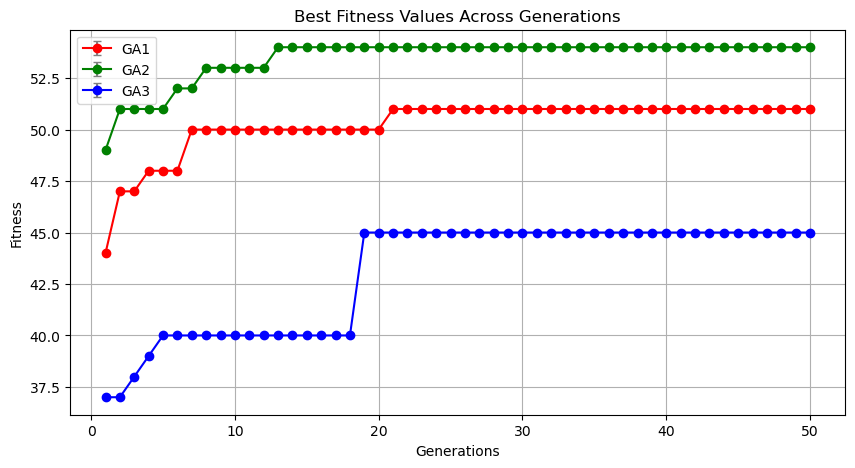

@@@@@@@@@@@@@@@@@@@
    Run: run_2_elitism    
@@@@@@@@@@@@@@@@@@@
Loading pokemon data from file...


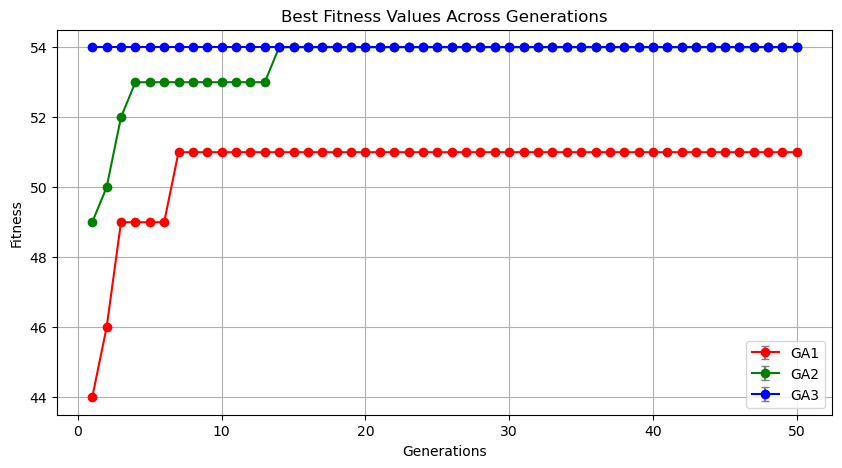

@@@@@@@@@@@@@@@@@@@
    Run: run_3_roulette    
@@@@@@@@@@@@@@@@@@@
Loading pokemon data from file...


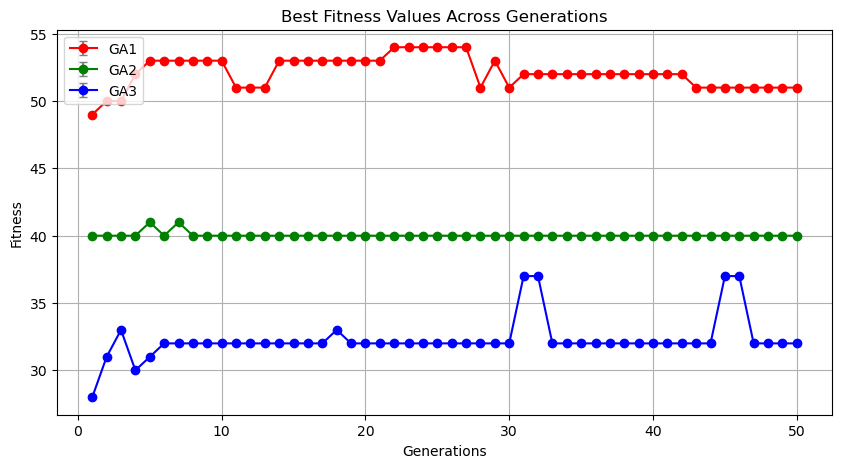

@@@@@@@@@@@@@@@@@@@
    Run: run_3_rank    
@@@@@@@@@@@@@@@@@@@
Loading pokemon data from file...


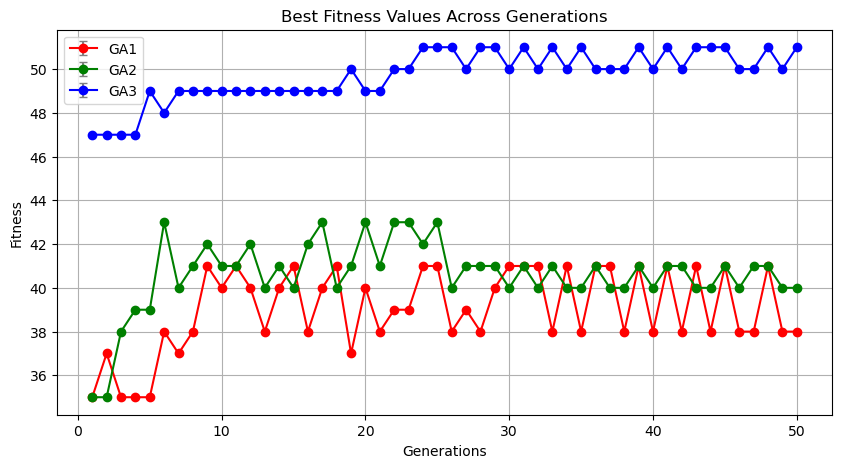

@@@@@@@@@@@@@@@@@@@
    Run: run_3_geneation_increase    
@@@@@@@@@@@@@@@@@@@
Loading pokemon data from file...


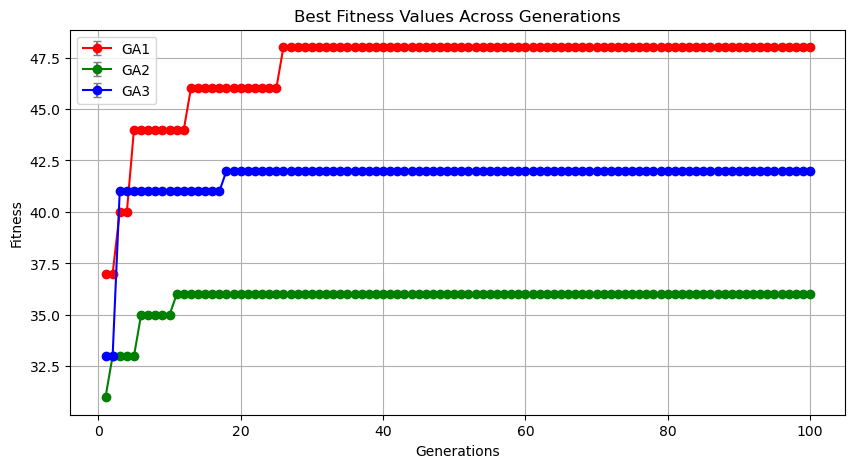

In [6]:
def main():
    # Change this to use path settings, otherwise default
    data_path = "/home/jovyan/Data/pokemon_data.json"
    run_settings_path = "/home/jovyan/Settings/run_settings.json"
    
    with open(run_settings_path, 'r') as f:
        run_settings_dict = json.load(f)
    
    for run, settings in run_settings_dict.items():
        print("@@@@@@@@@@@@@@@@@@@")
        print(f"    Run: {run}    ")
        print("@@@@@@@@@@@@@@@@@@@")
        execute_ga(settings, data_path)
    
if __name__ == "__main__":
    main()